### Imports

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

### Inputs

In [13]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = '../saved_models/FGSM/vanilla/vanilla_model_4e.pth'
use_cuda = True

### Model under attack

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
        self.gradients_fc3, self.gradients_fc2 = [], []
        self.fc3.register_backward_hook(self.saveGradientsFC3)
        self.fc2.register_backward_hook(self.saveGradientsFC2)
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.zeros(1, 200)   # mask for the forwardMask function for pruning
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)    
    
    def forwardDetect(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self.activations.append(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim=0)
    
    def forwardMask(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))*self.mask
        x = self.fc3(x)
        return F.softmax(x)
    
    def saveGradientsFC3(self, module, grad_input, grad_output):
        self.gradients_fc3.append(list(grad_output))
        
    def saveGradientsFC2(self, module, grad_input, grad_output):
        self.gradients_fc2.append(list(grad_output))

        
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

### FGSM attack

In [202]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Run attack
Check lines 17-18 and 36-37 to see what model are we running

In [203]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
#         output = model.forwardMask(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        print(init_pred.size(), target.size())
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
#         output = model.forwardMask(perturbed_data)
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [204]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) t

torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) t

KeyboardInterrupt: 

### Results

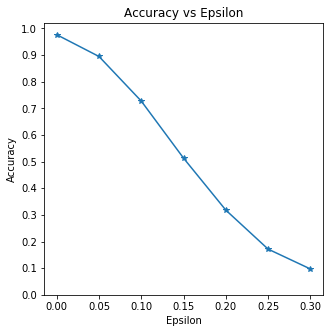

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

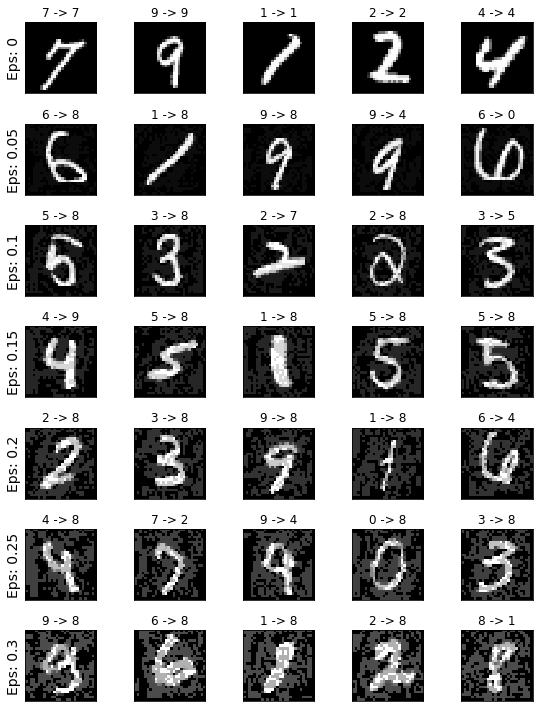

In [10]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Pruning FC2

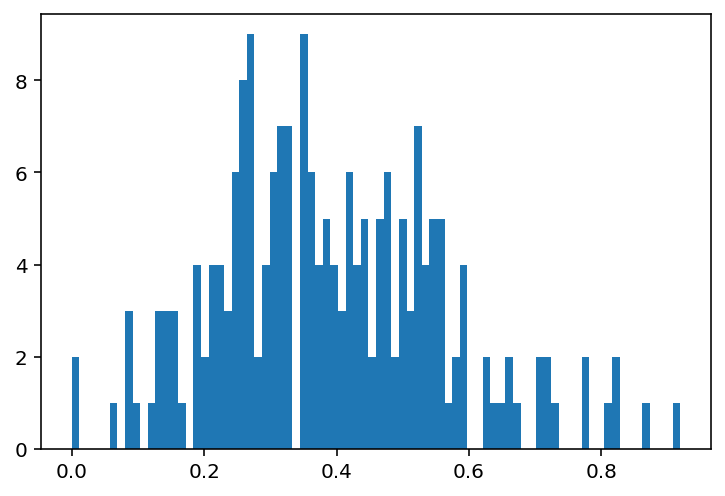

In [18]:
### Get activations in the layer previous to the output layer ###

model.eval() 
with torch.no_grad():
    for data, target in test_loader:
        output = model.forwardDetect(data.to(device))
activations = model.activations
n = len(activations)
element0 = activations.pop()
act = torch.zeros(n,element0.size(0),element0.size(1))
act[0,:,:] = element0

for e in range(n-1):
    elementX = activations.pop()
    act[e+1,:,:] = elementX

mean_activations = torch.mean(act,dim=[0,1])
ma = mean_activations.numpy()
plt.hist(ma,80)
plt.show()

In [56]:
model.eval() 
with torch.no_grad():
    for data, target in test_loader:
        output = model.forwardDetect(data.to(device))

In [61]:
# save different masks for different percentages

acc = []
masks = dict()

for percentage in range(10):
    s_ma, idx_ma = torch.sort(mean_activations)
    m = torch.ones(mean_activations.size()).to(device)
    nn = mean_activations.size(0)
    
    ind_r = round((percentage/10)*nn)
    m[idx_ma[:ind_r]] = 0.0
    n1 = m.sum()
    model.mask = m
    masks[percentage/10] = model.mask

In [67]:
# evaluate with the new masks

for pg, mask in masks.items():
    model.mask = mask
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model.forwardMask(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        acc.append(acc_test)

    print("Pruned {}  Accuracy: {} %".format(pg, 100*acc_test))

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Pruned 0.0  Accuracy: 97.66 %
Pruned 0.1  Accuracy: 97.61999999999999 %
Pruned 0.2  Accuracy: 97.52 %
Pruned 0.3  Accuracy: 97.3 %
Pruned 0.4  Accuracy: 96.95 %
Pruned 0.5  Accuracy: 96.73 %
Pruned 0.6  Accuracy: 96.25 %
Pruned 0.7  Accuracy: 95.7 %
Pruned 0.8  Accuracy: 94.08999999999999 %
Pruned 0.9  Accuracy: 82.98 %


In [76]:
fgsm_prune = dict()

# Run test for each epsilon and mask PG 
for pg, mask in masks.items():
    print('\n Pruned {}'.format(pg))
    accuracies = []
    examples = []
    results = dict()
    
    model.mask = mask
    for eps in epsilons:
        acc, ex = test(model, device, test_loader, eps)
        accuracies.append(acc)
        examples.append(ex)
    results['accuracies'] = accuracies
    results['examples'] = examples
    results['epsilons'] = epsilons
    fgsm_prune[pg] = results


 Pruned 0.0


C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	Test Accuracy = 9766 / 10000 = 0.9766
Epsilon: 0.05	Test Accuracy = 8948 / 10000 = 0.8948
Epsilon: 0.1	Test Accuracy = 7273 / 10000 = 0.7273
Epsilon: 0.15	Test Accuracy = 5130 / 10000 = 0.513
Epsilon: 0.2	Test Accuracy = 3179 / 10000 = 0.3179
Epsilon: 0.25	Test Accuracy = 1715 / 10000 = 0.1715
Epsilon: 0.3	Test Accuracy = 970 / 10000 = 0.097

 Pruned 0.1
Epsilon: 0	Test Accuracy = 9762 / 10000 = 0.9762
Epsilon: 0.05	Test Accuracy = 8938 / 10000 = 0.8938
Epsilon: 0.1	Test Accuracy = 7255 / 10000 = 0.7255
Epsilon: 0.15	Test Accuracy = 5106 / 10000 = 0.5106
Epsilon: 0.2	Test Accuracy = 3185 / 10000 = 0.3185
Epsilon: 0.25	Test Accuracy = 1744 / 10000 = 0.1744
Epsilon: 0.3	Test Accuracy = 983 / 10000 = 0.0983

 Pruned 0.2
Epsilon: 0	Test Accuracy = 9752 / 10000 = 0.9752
Epsilon: 0.05	Test Accuracy = 8906 / 10000 = 0.8906
Epsilon: 0.1	Test Accuracy = 7195 / 10000 = 0.7195
Epsilon: 0.15	Test Accuracy = 5025 / 10000 = 0.5025
Epsilon: 0.2	Test Accuracy = 3132 / 10000 = 0.3132
Epsilon

### Results

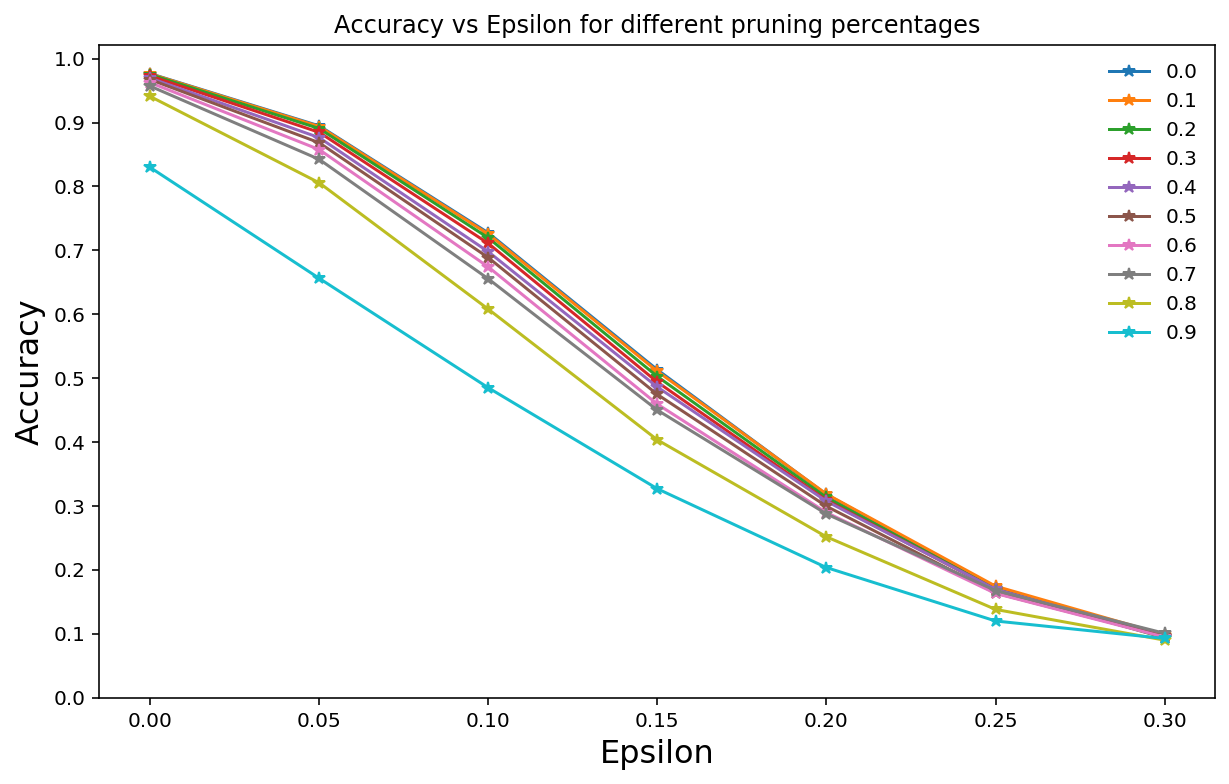

In [192]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))

for pg, results in fgsm_prune.items():
    plt.plot(epsilons, results['accuracies'], "*-", label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon for different pruning percentages")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

## Check gradients

In [188]:
eps = .1
model.mask = masks[0.5]
model.gradients_fc2, model.gradients_fc3 = [], []
acc, ex = test(model, device, test_loader, eps)

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.1	Test Accuracy = 6886 / 10000 = 0.6886


In [139]:
# model gradients of epsilon=0.1 and model NOT pruned
gradients_fc2_not_pruned = model.gradients_fc2
gradients_fc3_not_pruned = model.gradients_fc3

In [143]:
# model gradients of epsilon=0.1 and model YES pruned 90%
gradients_fc2_90_pruned = model.gradients_fc2
gradients_fc3_90_pruned = model.gradients_fc3